In [1]:
import arviz as az
import blackjax
import jax
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist

from jax import random
from numpyro.infer.util import initialize_model


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [7, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=0)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

[Text(0.5, 0, 'x'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Raw Data')]

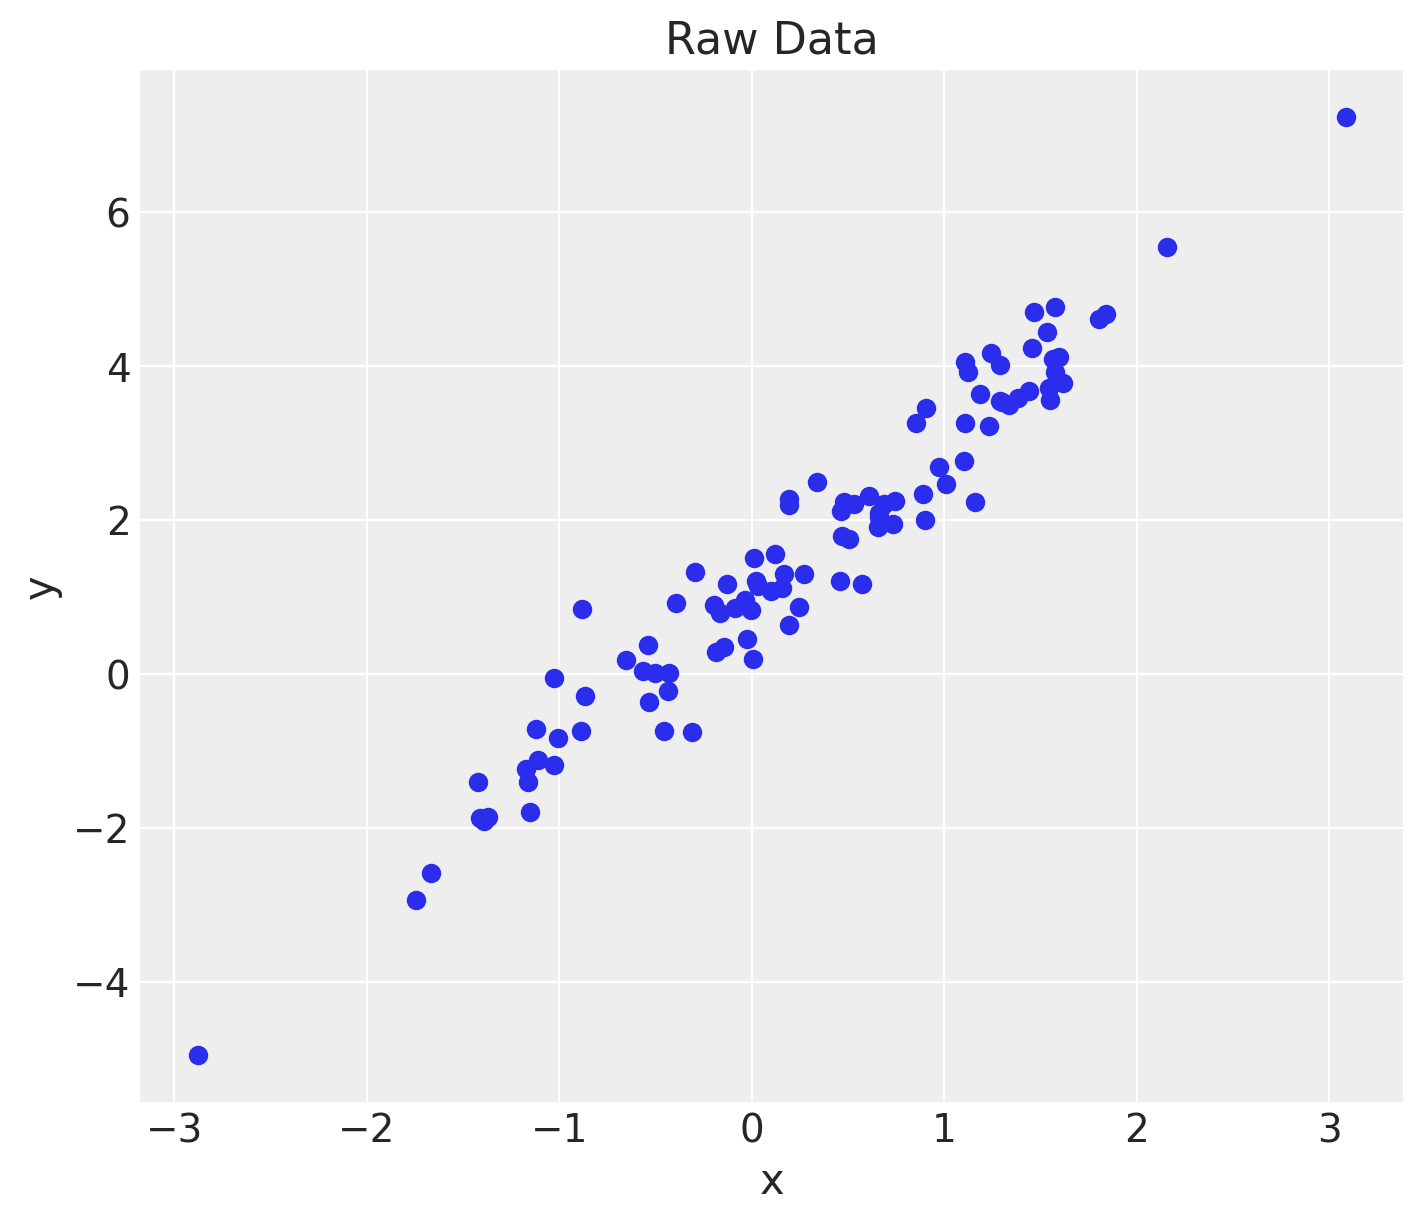

In [2]:
n = 100

rng_key, rng_subkey = random.split(rng_key)
x = random.normal(rng_subkey, (n,))

a = 1.0
b = 2.0
sigma = 0.5

rng_key, rng_subkey = random.split(rng_key)
epsilon = sigma * random.normal(rng_subkey, (n,))

y = a + b * x + epsilon

fig, ax = plt.subplots()
ax.plot(x, y, "o")
ax.set(xlabel="x", ylabel="y", title="Raw Data")

In [3]:
def model(x, y=None):
    a = numpyro.sample("a", dist.Normal(0.0, 2.0))
    b = numpyro.sample("b", dist.Normal(0.0, 2.0))
    sigma = numpyro.sample("sigma", dist.Exponential(1.0))
    mean = a + b * x
    with numpyro.plate("data", len(x)):
        numpyro.sample("likelihood", dist.Normal(mean, sigma), obs=y)

In [4]:
rng_key, rng_subkey = random.split(rng_key)
param_info, potential_fn, postprocess_fn, *_ = initialize_model(
    rng_subkey,
    model,
    model_args=(x, y),
    dynamic_args=True,
)


def logdensity_fn(position):
    func = potential_fn(x, y)
    return func(position)


initial_position = param_info.z

In [5]:
rng_key, rng_subkey = random.split(rng_key)
pathfinder_state, _ = blackjax.vi.pathfinder.approximate(
    rng_key=rng_subkey,
    logdensity_fn=lambda x: -logdensity_fn(x),
    initial_position=initial_position,
    ftol=1e-4,
)

rng_key, rng_subkey = random.split(rng_key)
posterior_samples, _ = blackjax.vi.pathfinder.sample(
    rng_key=rng_subkey,
    state=pathfinder_state,
    num_samples=4_000,
)

idata_pathfinder = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior_samples.items()
    },
)

posterior_samples_transformed = jax.vmap(postprocess_fn(x, y))(posterior_samples)

In [6]:
az.summary(data=idata_pathfinder, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 4000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.01,0.05,0.92,1.10,0.0,0.0,4114.14,3980.00,NaN
b,1.97,0.04,1.89,2.05,0.0,0.0,3707.86,4005.42,NaN
sigma,-0.72,0.07,-0.84,-0.59,0.0,0.0,3802.32,3336.00,NaN


Text(0.5, 0.98, 'Pathfinder Trace')

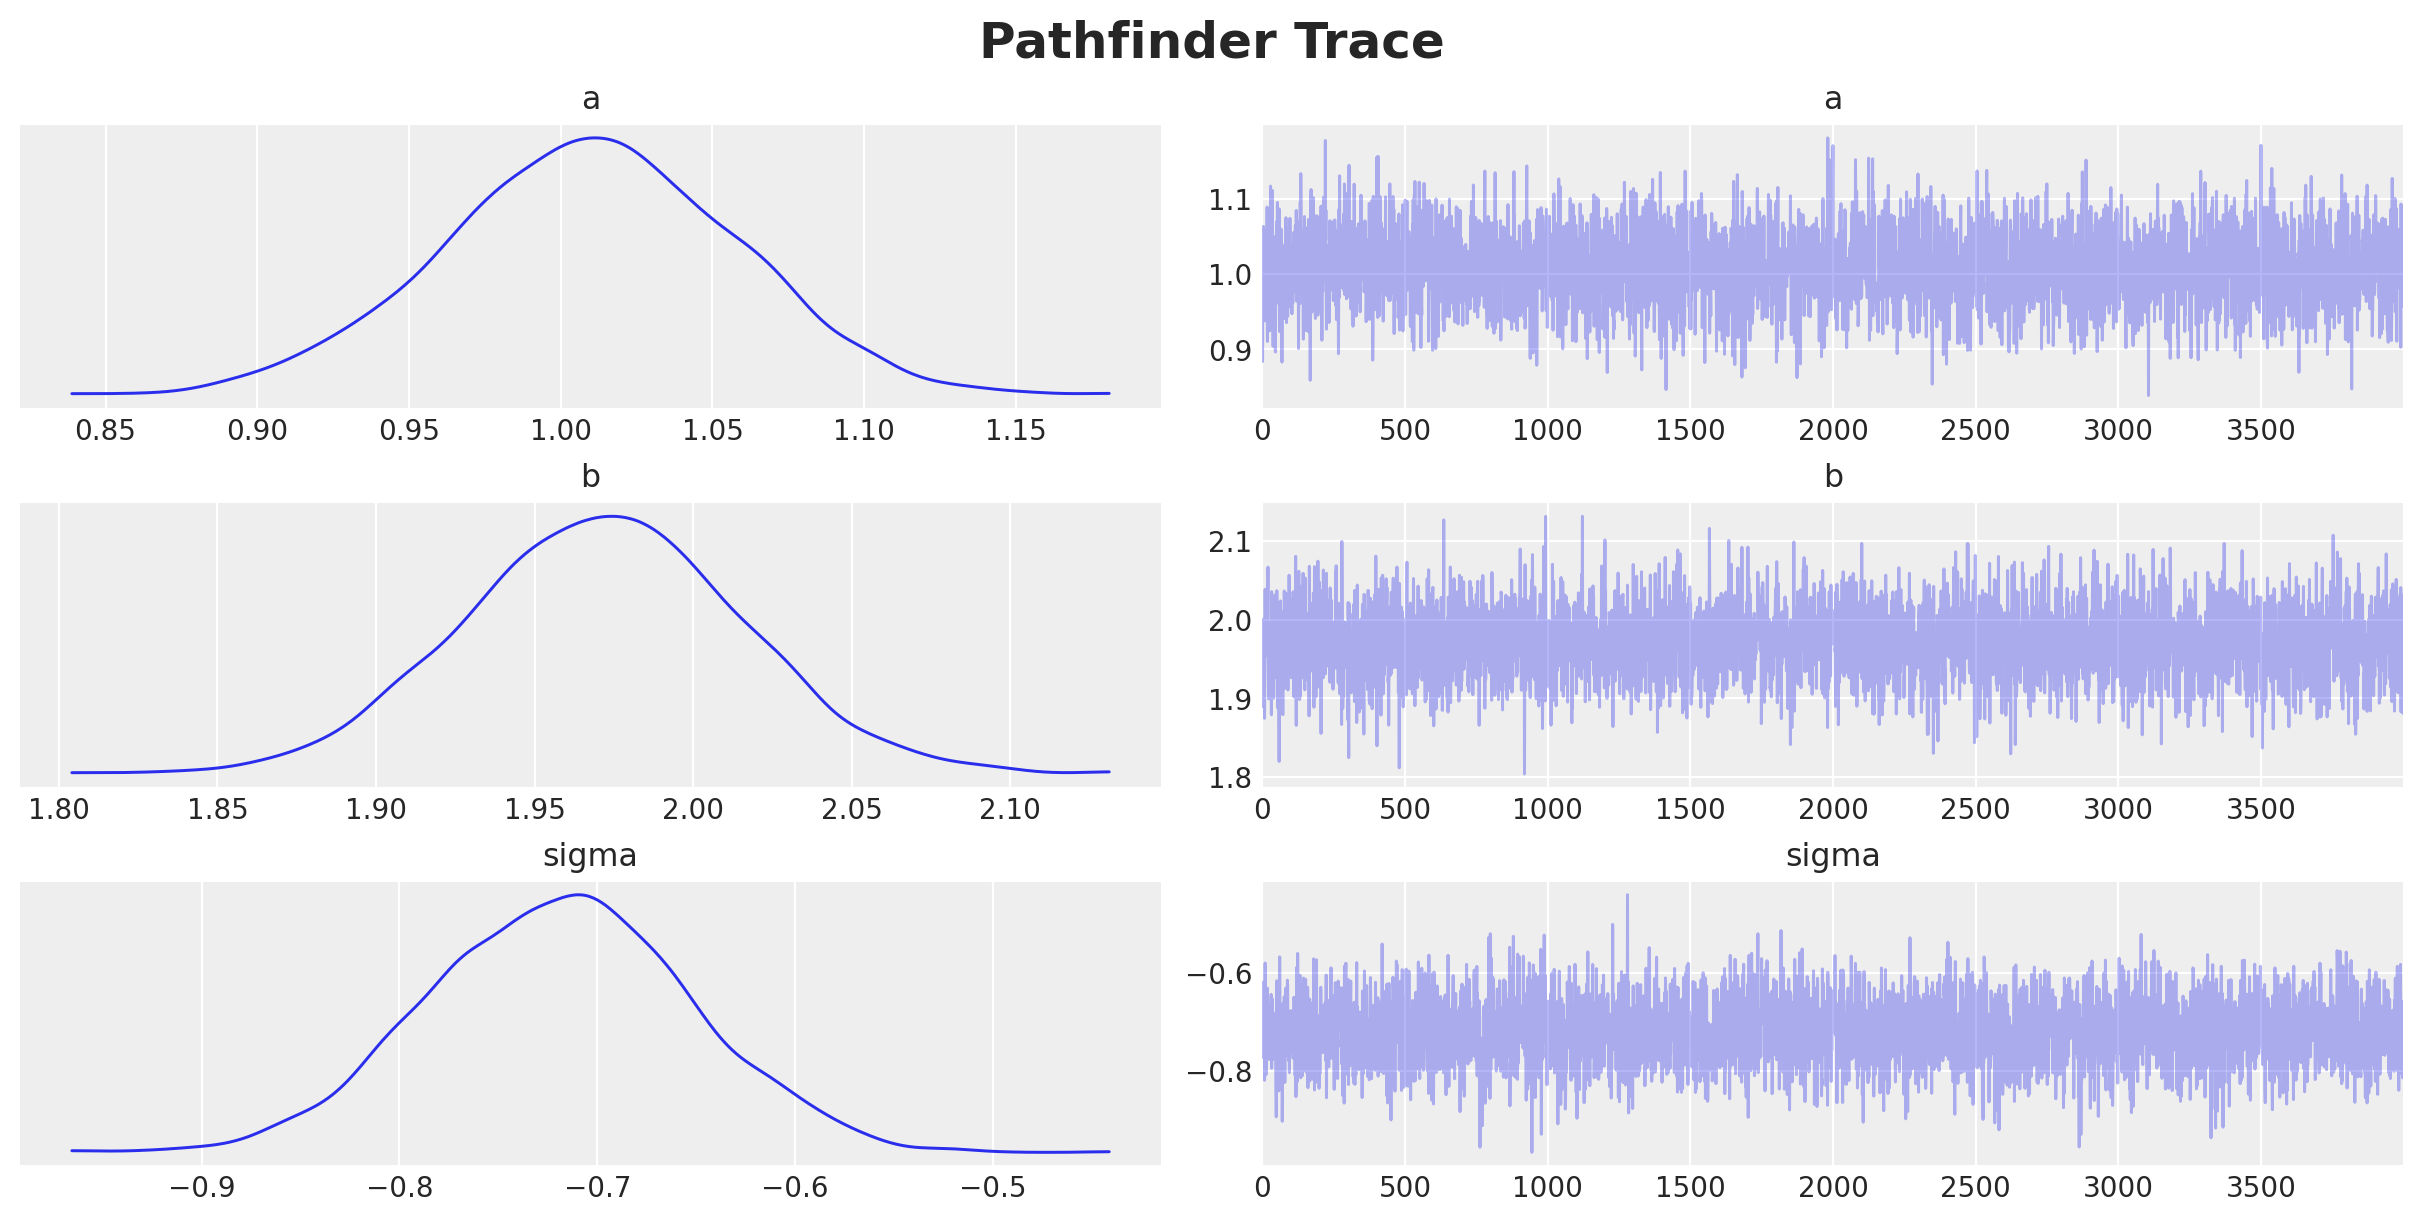

In [7]:
axes = az.plot_trace(
    data=idata_pathfinder,
    compact=True,
    backend_kwargs={"figsize": (12, 6), "layout": "constrained"},
)
plt.gcf().suptitle(t="Pathfinder Trace", fontsize=18, fontweight="bold")

In [8]:
posterior_samples_transformed

{'a': Array([0.9645677 , 0.88383734, 0.9891541 , ..., 0.98004097, 0.9882706 ,
        1.0226959 ], dtype=float32),
 'b': Array([1.9266534, 1.9878191, 1.8892442, ..., 1.8811033, 1.9484416,
        1.9543549], dtype=float32),
 'sigma': Array([0.49401087, 0.49979746, 0.46184635, ..., 0.44290245, 0.51779646,
        0.49234945], dtype=float32)}